# Siguientes pasos

 - Con los valores de cada uno de las 4 caracteristicas del ABCD, se debe encontrar los valores que determinan si la caracteristica se cumple o no. (E.j. si 'x' valor significa que la lesión es asimetrica) ver pipeline y estimación de melanoma.
 - Revisar la forma en que se realiza el cálculo de dimensión fractal, el código no es propio y puede tener errores.
 - Dar una descripción de check_div en MCDM, sirve para revisar cuales son los colores que esta detectando el MCDM, ya que no es siempre claro las direcciones en las cuales funcionan los valores que reporta el MCDM.

# ABCD - It is a technique used for detecting the probability of a lesion being a melanoma.

### A -  Asimetría
<hr style="border:2px solid gray"> </hr>

Esta sección hace referencia a la asimetría de una lesión. Entre más asimétrica es una lesión es más probable que sea clasificada como melanoma. El código de asimetría es producto de esta investigación. No se ha probado, por lo cual no se recomienda el uso de este hasta que se haya probado de una manera más completa. Sin embargo, tomando en cuenta el alcance de este proyecto se considera funcional. A continuación se presenta una explicación del funcionamiento del código.

Se asume que un nevo(lunar) debe ser lo más circular posible[1]. Idealmente un círculo. Por lo cual se idealiza este concepto y se compara la imagen con un círculo. Esto se hace por medio de un puntaje. Si este puntaje es muy alto se dice que el objeto no es simétrico y si es muy bajo se considera simétrico. Para lograr esto primeramente se le debe aplicar un umbral a la imagen de forma que la piel sana y la piel no sana (lesión) se distingan claramente. En este caso se optó por una imagen binaria en la cual el valor de 0 (negro) corresponda a piel sana y 255 (blanco) a la lesión.


Se utilizó el umbral de Otsu, ya que este tiene menos dependencia del tono de piel y es capaz de adaptarse[2]. Esto con el propósito de mantener el código relevante y que necesite poco mantenimiento a futuro. Una vez que ya se aplicó Otsu, se selecciona la lesión continua de mayor tamaño, suponiendo que este representa la mayor área de la lesión. Se rellena el umbral seleccionado, de manera que no tenga ningún pixel negro dentro de sí. Con esto listo, se deshace de los demás umbrales para que estos no provoquen problemas en la siguiente etapa. (En la figura se puede observar esto).


El siguiente paso consiste de dos partes, primero se gira la imagen con respecto a su centro. De manera que se dé una vuelta completa, esto con el objetivo de poder analizar la imagen desde diferentes ángulos, de forma que no se prefiera uno sobre otro. Segundamente se calcula un centro tanto en el eje "y" como "x". De forma que se pueda dividir la imagen a lo largo de los dos ejes para hacer el cálculo de la simetría.  Cada vez que se gira la imagen se vuelven a calcular los centros de los ejes. Para calcular la simetría se hace una resta de ambos lados de forma que si uno es más largo que el otro no se considera simétrico. Los resultados de las restas se suman a contador global que más tarde determinará si una imagen es simétrica o no.

Por el momento el código no determina si una lesión es un melanoma. Esa funcionalidad se brindará en una versión futura.

Ejemplo:
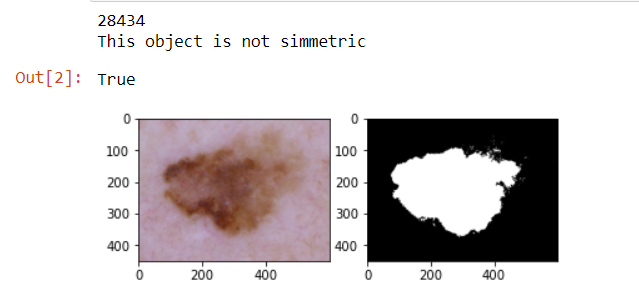


[1]Bono, A., Tomatis, S., Bartoli, C., Tragni, G., Radaelli, G., Maurichi, A., & Marchesini, R. (1999). The ABCD system of melanoma detection: A spectrophotometric analysis of the asymmetry, border, color, and dimension. Cancer: Interdisciplinary International Journal of the American Cancer Society, 85(1), 72-77.

[2]Poorna, S. S., Reddy, M. R. K., Akhil, N., Kamath, S., Mohan, L., Anuraj, K., & Pradeep, H. S. (2020). Computer Vision Aided Study for Melanoma Detection: A Deep Learning Versus Conventional Supervised Learning Approach. In Advanced Computing and Intelligent Engineering (pp. 75-83). Springer, Singapore.


In [1]:
import cv2 #Image Library
import numpy as np #Numpy library
import statistics
import imutils
from statistics import mean

def assymetry(imagePath):
    """
    Evaluate the assymetry of an image
    
    Parameters:
     imagePath[string]: The relative path to the image
     
    Returns:
        totsymmetry [float]: The total assymetry found in all the columns
    """ 
    image = cv2.imread(imagePath) #read the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Same image but in grayscale, this is done for calculating the threshold
    ret,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#get contours of the lesion
    cv2.drawContours(thresh, contours, -1, (255,255,255), thickness=cv2.FILLED)#fill in the contour
    
    #find largest contour and remove the smaller ones
    max_area = -1
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if area>max_area:
            max_area = area
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if (area < max_area):
            cv2.drawContours(thresh, [contours[i]], -1, (0,0,0), -3)
    
    #caclulate symmetry
    totsymmetry = 0
    for angle in np.arange(0, 360, 15): #rotate 360 in increments of 15
        rotated = imutils.rotate_bound(thresh, angle)
        [xsym,ysym]=findsymmetry(rotated)
        totsymmetry = xsym+ysym
    #return [xsym,ysym,totsymmetry]
    return [xsym,ysym,totsymmetry,totsymmetry]

def findsymmetry(im):
    """
    Finds the overall symmetry of the image, to do this it traverses it line by line, checking each one for it´s symmetry
    
    Parameters:
     im [2D-Matrix]: is the image, already binary and rotated
     
    Returns:
     an array containing:
      yassymetry [int]: The total assymetry found in all the columns
      xassymetry [int]: The total assymetry found in all the rows
    """ 
    [y_max,x_max] = im.shape #get width and length of the image
    x = []
    xmina=[] #values further left
    xmaxa=[] #values further right
    y_max-=1
    x_max-=1
    for y in range(y_max): #find symmetry in all columns
        [x_next,xmin,xmax] = findmiddle(im[y,:],x_max)
        if(x_next != 0):
            x.append(x_next)   #middle of the current column
            xmina.append(xmin) #min white pixel
            xmaxa.append(xmax) #max white pixel
    x_line = int(mean(x)) #get aproximated middle as the mean of **all** the columns
    xassymetry = 0
    for i in range(len(xmina)): #compare length of both sides, xmax and xmin
        xassymetry += abs(abs(xmaxa[i]-x_line)-abs(xmina[i]-x_line)) #symmetrical if this gives zero
    #centre line for y
    y = []
    ymina=[] #values further up
    ymaxa=[] #values further down
    for x in range(x_max):#find symmetry in rows
        [y_next,ymin,ymax] = findmiddle(im[:,x],y_max)
        if(y_next != 0):
            y.append(y_next)    #middle of the current row
            ymina.append(ymin)  #highest white pixel of the current row
            ymaxa.append(ymax)  #lowest white pixel of the current row
    y_line = int(mean(y)) #aproximate y centre of the whole image
    yassymetry = 0
    for i in range(len(ymina)):
        yassymetry += abs(abs(ymaxa[i]-y_line)-abs(ymina[i]-y_line))
    return [yassymetry,xassymetry]


def findmiddle(line,max_):
    """
    Finds the middle in the current line
    
    Parameters:
     line [1D-Matrix]: is the current line, can be row or column
     max_ [int]: is the len of said line
     
    Returns:
     an array containing:
      [float]: the halfway point between the first and last white pixel in a line, if there's no
      white pixel it returns 0
      min_[int]: The position of the first white pixel
      max_[int]: The position of the last white pixel
    """ 
    min_=0
    while(line[min_] != 255):
        min_+=1
        if min_>=max_:#has no white pixels
            return [0,0,0]
    while(line[max_-1] != 255):
        max_-=1
    return [((max_-min_)/2)+min_,min_,max_]

def eval_symm(imagePath,totsymmetry):
    """
    Evaluates the symmetry value and determines if it is symmetrical or assymetrical
    
    Parameters:
    imagePath[string]: The relative path to the image
    totsymmetry [float]: The total assymetry found in all the columns (obtained from assymetry())
     
    Returns:
        True if the lesion is considered assymmetrical
        False if it is not considered assymetrical
    """
    image = cv2.imread(imagePath) #read the image
    [x,y,_] = image.shape
    if(totsymmetry/(x*y) > 0.1):
        return True
    return False

SyntaxError: invalid syntax (Temp/ipykernel_8268/1805065391.py, line 1)

### B -  Bordes

<hr style="border:2px solid gray"> </hr>

La detección de bordes es una de las tareas que se han implementado de numerosas formas para los melanomas. Cada implementación con sus ventajas y desventajas. En la sección anterior, se utilizó el umbral de Otsu para detectar el borde. Sin embargo, en esta sección, el borde de la lesión no se refiere a la detección del borde. Para eso se volverá a utilizar Otsu.

Borde en este contexto se refiere a las cualidades que los dermatólogos buscan en el borde de lesiones, en lugar de detectarlo. Hay dos cualidades principales que los médicos buscan en los posibles bordes del melanoma, su definición y regularidad. [1] Dado que ambas cualidades son importantes en el diagnóstico de un melanoma, se desarrollaron dos algoritmos diferentes para este atributo.

Primero se describirá el proceso para detectar bordes mal definidos de la lesión cutánea. Esto se refiere a aquellas fronteras cuyos extremos no están claramente definidos. Por esta razón, el código se implementa con la ayuda de una función de detección de bordes. Se utilizó el algoritmo de Otsu dado que el código ya se implementó en la parte de asimetría.

El código funciona de la siguiente manera: después de que se detecta un borde inicial y se ha calculado un valor de umbral (esto se obtiene de la función de umbral de OpenCV), este valor se incrementa y disminuye en un 10%. Esto provoca cambios en la detección de la lesión, lo que significa que si el borde de la lesión no es pronunciado, el cambio se notara mucho. Se hace una comparación entre ambas nuevas áreas. Cuanto mayor sea el cambio, mayor será la puntuación que tendrá una lesión. Cuanto mayor sea la puntuación, más se considerará como melanoma.

En la figura 1, se puede observar cómo se vería esto en un borde de imagen bien definido. En comparación con la figura 2, que posee bordes menos definidos.

![Figure 1](Images/Showcase/welldefinedborders.PNG "Figura 1")
<h3><center>Figura 1: Bordes bien definidos</center></h3>

![Figure 2](Images/Showcase/poordefinedborders.PNG "Figura 2")
<h3><center>Figura 2: bordes poco definidos</center></h3>

 En segundo lugar está la dimensión, fractalidad o (a veces denominado) "irregularidad" de los bordes. [1] [2] [3]. Este es un campo más estudiado y aplicado para la detección del melanoma mediante visión artificial. En este caso, se utilizaron dimensiones fractales [4] [5] [6] [7] [8] pero existen otros métodos [9] [10]. Este código necesita poca explicación porque está compuesto por dos partes diferentes. Primero, la imagen se convierte en una representación binaria. Nuevamente, usando el umbral de Otsu. Después de esto, se utiliza un algoritmo de dimensión fractal de recuento de cajas para estimar la dimensión fractal de la imagen. Esto se hace con una puntuación. Esa puntuación suele estar entre 1 y 2. Cuanto más alta sea la puntuación (significa que este es irregular), más melanoma se considerará como la lesión.


[1]Friedman, R. J., Rigel, D. S., &amp; Kopf, A. W. (1985). Early detection of malignant melanoma: The role of physician examination and self-examination of the skin. CA: A Cancer Journal for Clinicians, 35(3), 130–151. https://doi.org/10.3322/canjclin.35.3.130 

[2]Naheed R. Abbasi, M. P. H. (2004, December 8). Early diagnosis of cutaneous melanoma. JAMA. https://jamanetwork.com/journals/jama/fullarticle/199929.

[3]S. A. Mahdiraji, Y. Baleghi and S. M. Sakhaei, "BIBS, a New Descriptor for Melanoma/Non-Melanoma Discrimination," Electrical Engineering (ICEE), Iranian Conference on, 2018, pp. 1397-1402, doi: 10.1109/ICEE.2018.8472701.

[4]Andreassi, L., Perotti, R., Rubegni, P., Burroni, M., Cevenini, G., Biagioli, M., ... & Barbini, P. (1999). Digital dermoscopy analysis for the differentiation of atypical nevi and early melanoma: a new quantitative semiology. Archives of dermatology, 135(12), 1459-1465.

[5]Carbonetto, S. H., & Lew, S. E. (2010, August). Characterization of border structure using fractal dimension in melanomas. In 2010 Annual International Conference of the IEEE Engineering in Medicine and Biology (pp. 4088-4091). IEEE.

[6]Ng, V., & Coldman, A. (1993, October). Diagnosis of melanoma with fractal dimensions. In Proceedings of TENCON'93. IEEE Region 10 International Conference on Computers, Communications and Automation (Vol. 4, pp. 514-517). IEEE.

[7]Qin, B., Ma, L., & Xu, W. (2010, June). Comparative study on boundary Structural Irregularity using Local FD and Curvature analysis for Melanoma detection. In 2010 4th International Conference on Bioinformatics and Biomedical Engineering (pp. 1-4). IEEE.

[8]Vocaturo, E., Zumpano, E., & Veltri, P. (2018, July). Features for melanoma lesions characterization in computer vision systems. In 2018 9th International Conference on Information, Intelligence, Systems and Applications (IISA) (pp. 1-8). IEEE.

[9]Lee, T. K., & Atkins, M. S. (2000, June). New approach to measure border irregularity for melanocytic lesions. In Medical Imaging 2000: Image Processing (Vol. 3979, pp. 668-675). International Society for Optics and Photonics.

[10]Aribisala, B. S., & Claridge, E. (2005, September). A border irregularity measure using a modified conditional entropy method as a malignant melanoma predictor. In International Conference Image Analysis and Recognition (pp. 914-921). Springer, Berlin, Heidelberg.

### Border Definition

In [1]:
import cv2 #Image Library
import numpy as np #Numpy library
import matplotlib.pyplot as plt #matplotlib to show images
import statistics
import imutils
from statistics import mean

def border_definition(imagePath):
    """
    Evaluate the definition of the lesion border
    
    Parameters:
     imagePath[string]: The relative path to the image
     
    Returns:
      border_score [int]: The score given to the border, the higher this score,
          the lower the definition of the melanoma border
    """ 
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    _,thresh_high = cv2.threshold(gray,ret+ret*0.1,255,cv2.THRESH_BINARY_INV)#add 10% to the threshold
    _,thresh_low = cv2.threshold(gray,ret-ret*0.1,255,cv2.THRESH_BINARY_INV)#subtract 10% to the threshold
    xor = cv2.bitwise_xor(thresh_high, thresh_low) #difference in the thresholds
    
    border_score = cv2.countNonZero(xor) #count non zero pixels
    return border_score

def eval_border_definition(imagePath,border_score):
    """
    Evaluates the border definition value and determines if it is well defined or not
    
    Parameters:
    imagePath[string]: The relative path to the image
    border_score [int]: The score given by border_definition()
     
    Returns:
        True if the lesion is considered to have badly defined borders
        False if it has well defined borders
    """
    image = cv2.imread(imagePath) #read the image
    [x,y,_] = image.shape
    if(border_score/(x*y) > 0.1):
        return True
    return False

### Fractal Dimension

In [24]:
# -----------------------------------------------------------------------------
# From https://en.wikipedia.org/wiki/Minkowski–Bouligand_dimension:
#
# In fractal geometry, the Minkowski–Bouligand dimension, also known as
# Minkowski dimension or box-counting dimension, is a way of determining the
# fractal dimension of a set S in a Euclidean space Rn, or more generally in a
# metric space (X, d).
# -----------------------------------------------------------------------------

#Tomado de https://gist.github.com/viveksck/1110dfca01e4ec2c608515f0d5a5b1d1

import numpy as np
import cv2 #Image Library
import matplotlib.pyplot as plt #matplotlib to show images
import statistics
import imutils
from statistics import mean


def fractal_dimension(Z, threshold=0.9):
    """
    Estimate the fd (fractal dimension) of an image
    
    Parameters:
     Z[2D-Matrix]: Binary image
     threshold [float]: a value for consideration of fractality, in this case it is left it default
     
    Returns:
      thresh [float]: Score of the image fractal dimension, the higher, the more melanoma like it is 
    """ 

    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])


    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

def binary(imagePath):
    """
    Evaluate the assymetry of an image
    
    Parameters:
     imagePath[string]: The relative path to the image
     
    Returns:
      thresh [2D-Matrix]: Representation of the image as a binary image with the lesion as white
    """ 
    image = cv2.imread(imagePath) 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY ) 
    ret,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(thresh, contours, -1, (255,255,255), thickness=cv2.FILLED)
    max_area = -1
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if area>max_area:
            max_cont = contours[i]
            max_area = area
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if (area < max_area):
            cv2.drawContours(thresh, contours, -1, (0,0,0), 3) #fill in the smaller contours
    return thresh

def image_fractality(imagePath):
    """
    Evaluate the fractal dimension of an image
    
    Parameters:
     imagePath[string]: The relative path to the image
     
    Returns:
      fd_score [float]: Score of the image fractal dimension, the higher, the more melanoma like it is 
    """ 
    bin_image = binary(imagePath)
    fd_score = fractal_dimension(bin_image)
    return fd_score

def eval_border_fractality(imagePath,image_fractality):
    """
    Evaluates the border fractality value and determines if it is well defined or not
    
    Parameters:
    imagePath[string]: The relative path to the image
    image_fractality [float]: The score given by image_fractality()
     
    Returns:
        True if the lesion is considered to be jagged 
        False if it does not appear to be a jagged lesion
    """
    image = cv2.imread(imagePath) #read the image
    if(image_fractality >= 1.1):
        return True
    return False

## C - Color
___

La presencia de varios colores en una lesión cutánea es una señal de advertencia. Se considera uno de los primeros signos de advertencia de un melanoma. Si bien los lunares benignos suelen tener un solo tono de marrón, un melanoma puede tener diferentes tonos de color, esto se llama abigarramiento. [1] Esta es la clave para determinar el factor C (color) en ABCD.

Dado que se trata de un análisis de color para un sistema de procesamiento de imágenes, el espacio de color debe elegirse con cuidado. Especialmente dado que elegir el incorrecto podría conducir a resultados incorrectos. En este caso se eligió CIELab, ya que toma en cuenta más colores, además, no depende del medio en el que se representa (pantalla, impresora, etc) [2] [3]

Para esta aplicación se eligió un análisis de histograma. Se han propuesto varias formas de estimar los colores del melanoma [4]. Sin embargo, la mayoría de estos son demasiado complicados y estarían fuera del alcance de este proyecto. Además, el uso de histogramas ha demostrado ser eficaz. [5]

El proceso de imágenes en esta categoría consta de 3 principales partes . Primero se aplica un umbral a las imágenes para obtener una máscara binaria (representación) de la lesión. Una vez más, se utilizó el umbral de Otsu. Una vez ya calculada la máscara, se debe volver a aplicar a la imagen original, esta es la segunda parte. El último paso es utilizar un histograma y calcular el cambio, así como los colores que tiene la lesión. Cuanto mayor sea la variación, mayor será el valor que se devuelve.

Algunos colores son más importantes que otros, los colores más oscuros y de tonos azules parecen tener mayores implicaciones del melanoma. [6] Para dar cuenta de esto, el algoritmo cuenta con un peso. Cuanto más oscuro sea el tono, mayor valor representa para el resultado general.

[1]Bono, A., Tomatis, S., Bartoli, C., Tragni, G., Radaelli, G., Maurichi, A., & Marchesini, R. (1999). The ABCD system of melanoma detection: A spectrophotometric analysis of the asymmetry, border, color, and dimension. Cancer: Interdisciplinary International Journal of the American Cancer Society, 85(1), 72-77.

[2] Kaur, A., & Kranthi, B. V. (2012). Comparison between YCbCr color space and CIELab color space for skin color segmentation. International Journal of Applied Information Systems, 3(4), 30-33.

[3]S. Sabbaghi, M. Aldeen, R. Garnavi, G. Varigos, C. Doliantis and J. Nicolopoulos, "Automated colour identification in melanocytic lesions," 2015 37th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC), 2015, pp. 3021-3024, doi: 10.1109/EMBC.2015.7319028.

[4]METODO CON GRAFOS DE SUPERPIXEL    Annaby, M.H., Elwer, A.M., Rushdi, M.A. et al. Melanoma Detection Using Spatial and Spectral Analysis on Superpixel Graphs. J Digit Imaging 34, 162–181 (2021). https://doi-org.ezproxy.itcr.ac.cr/10.1007/s10278-020-00401-6

[5] Histograma   Soumya, R. S., Neethu, S., Niju, T. S., Renjini, A., & Aneesh, R. P. (2016, July). Advanced earlier melanoma detection algorithm using colour correlogram. In 2016 International Conference on Communication Systems and Networks (ComNet) (pp. 190-194). IEEE.

[6]Menzies SW, Moloney FJ, Byth K, et al. Dermoscopic Evaluation of Nodular Melanoma. JAMA Dermatol. 2013;149(6):699–709. doi:10.1001/jamadermatol.2013.2466


New references:

https://www.elsevier.es/es-revista-medicina-familia-semergen-40-articulo-dermatoscopia-principiantes-ii-estructuras-dermatoscopicas-S1138359315004219



In [32]:
import cv2 #Image Library
import numpy as np #Numpy library
import matplotlib.pyplot as plt #matplotlib to show images

def colour(imagePath):
    """
    Evaluate the coulours of an image
    
    Parameters:
     imagePath[string]: The relative path to the image
     
    Returns:
        score [float]: The score of the colour
    """ 
    image = cv2.imread(imagePath) #read the image
    image_CIELab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Same image but in grayscale, this is done for calculating the threshold
    ret,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#get contours
    cv2.drawContours(thresh, contours, -1, (255,255,255), thickness=cv2.FILLED)#fill in the contours as white
    
    #find largest contour and remove the smaller ones
    max_area = -1
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if area>max_area:
            max_area = area
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if (area < max_area):
            cv2.drawContours(thresh, [contours[i]], -1, (0,0,0), thickness=cv2.FILLED)
    [h,w,_] = image.shape #get width and length of the image
    
    #create the mask, from the CIELab image and the binary image
    for y in range(0, h):
        for x in range(0, w):
            if(thresh[y,x] == 0):
                image_CIELab[y,x,0] = 0
                image_CIELab[y,x,1] = 0
                image_CIELab[y,x,2] = 0
    histr = cv2.calcHist([image_CIELab],[0],None,[256],[1,256])
    score = 0
    for x in range(len(histr)):
        score += histr[x]*(1000/(x+50)) 
    return score

def eval_colour(imagePath,colour):
    """
    Evaluates the border definition value and determines if it is well defined or not
    
    Parameters:
    imagePath[string]: The relative path to the image
    image_fractality [float]: The score given by the function colour()
     
    Returns:
        True if the lesion is considered to be jagged 
        False if it does not appear to be a jagged lesion
    """
    image = cv2.imread(imagePath) #read the image
    [x,y,_] = image.shape
    print(colour[0],colour[0]/(x*y))
    if(colour/(x*y) >= 2.1):
        return True
    return False

## MCDM
 
  El MCDM no es una de las propiedades del ABCD, sino que este representa una métrica para medir la diferencia que hay entre colores. Este método fue una sugerencia por parte de los investigadores, para de esta forma poder calcular la diferencia entre los colores que se ubican dentro de las lesiones. Sin embargo, para poder analizar este resultado era necesario primero separar o segmentar los diferentes colores que se encuentran en las lesiones. CIELab se ha utilizado en implementaciones previas.[1][2]
 
 Para la segmentación de los colores se utilizó CIELch, el cual es un espacio relacionado con el CIELab. La diferencia es que CIELch emplea coordenadas polares. Por lo que el c representa la distancia y h el ángulo. Por el momento se está usando varios criterios para dividir el angulo en n espacios. No más, la distancia siempre se encuentra dividida en 3 segmentos dentro de los angulos. 
 
 Primeramente, se decidió utilizar una imagen típica de una rueda de colores. Estas usualmente se hacen con el formato de RGB. Por lo que cuando se transformó al formato CIELab y después a CIELch se mostraban algunos colores pero otros no. Por lo que no se pudo verificar que el código funcionara de manera correcta. Por esta razón se decidió buscar una imagen creada para CIELab. Esta se pede observar en la figura 1. Sin embargo, como se observa esta tampoco muestra una buena representación de los colores. Las líneas no se definen bien y algunos colores son más grandes que otros. Se cree que el problema proviene del formato en el cual la imagen se ha guardado, esta no muestra a fidelidad como fue generada.
 
 ![normal-image.png](Images\Showcase\normal-image.png)
<center> Figura 1. Rueda de color CIELab. </center>
 
 Para combatir el problema de una imagen no fiel a CIELch, se decidió generar una imagen propia. Con el propósito de probar el código previo. Esto sirvió para detectar algunas fallas en la lógica y en la manera en la que se realizaban los cálculos. El código para generar la imagen se puede mostrar en función cacl_cielab. La cual se encuentra en la siguiente celda.
 
 El primer problema que se detectó con el cambio a una imagen generada es que la biblioteca openCV no se puede utilizar para este fin. Esto ya que no presenta representación del espacio CIELch, además el rango de colores que se usan no es fiel a la representación de CIELab. Por lo que calcular manualmente los valores CIELch no van a concordar. Para reemplazar OpenCv se empleó SKImage (Sci-Kit Image). El cual es una biblioteca de Python.
 
 Por otra parte, se recomienda mantener el código de prueba, ya que permite mostrar el comportamiento del código. Además, sirve como referencia para ver cuáles son los posibles colores que se están seleccionando en la imagen. Lo cual es difícil comprobar sin un índice.
 
 La métrica que se varían son la de los ángulos en el código. Esto se puede verificar con la figura 2. La cual muestra como es que variar la cantidad de espacios cambia la imagen resultante. Por otra parte, no se toma en cuenta la característica L de la imagen. Para demostrar esto, se puede referenciar a la figura 3. En la cual todas las muestras representan los mismos valores de c y h, solo se varía el criterio L. Se puede observar que el resultado es el mismo aunque no sean los mismos colores. El código permite ingresar el valor L como parámetro para realizar pruebas adicionales.
 
 ![allsegments](Images\Showcase\allsegments.png)
<center> Figura 2. Imagen semgmentada </center>
 
  ![allL](Images\Showcase\allL.png)
 <center>Figura 3. Imagen con diferentes valores de L</center>
 
 Para imágenes de melanomas el procedimiento agrega una acción más. La de separación de la piel sana de la lesión. Esto se hace de la misma forma que en el proceso del color. Para que se ejecute de manera correcta primeramente se hace un enmascaramiento de la imagen y después se analizan los colores. Se puede observar algunos resultados de ejemplo en la figura 4.
 
 ![allL](Images\Showcase\allMCDMtests.png)
 <center>Figura 4. Pruebas con la segmentación de colores.</center>


 
 
 
 [1] Wang, M., Xiao, K., Wuerger, S., Cheung, V., & Luo, M. R. (2015, October). Measuring human skin colour. In Color and Imaging Conference (Vol. 2015, No. 1, pp. 230-234). Society for Imaging Science and Technology. 
 
 
 [2] Wang, M., Xiao, K., Luo, M. R., Pointer, M., Cheung, V., & Wuerger, S. (2018). An investigation into the variability of skin colour measurements. Color Research & Application, 43(4), 458-470.

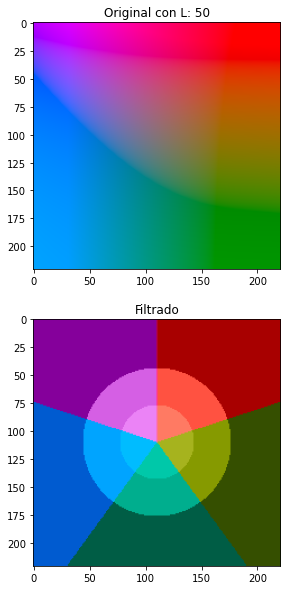

In [34]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io, color

def div_n(resLch,n):
    """
    Divide the image based on its colours(in CIELch) only takes into account the c and h from CIELch. 
    L doesnt change the outcome.
    While it divides the image based on its angle, it always divides c into thirds
    
    Parameters:
     resLch[float]: The ingage to be converted in CIELch format, color.rgb2LCH was used, so it expects this format
     n int: the amount that the image will be sectioned into
     
    Returns:
        resfiltered [float]: The image filtered into the colours, it is rgb format
    """ 
    [h,w,_] = resLch.shape #get width and length of the image
    resfiltered = np.zeros((h,w,3), dtype=float)
    #create the mask, from the CIELab image and the binary image
    pi_n = (2*np.pi)/n
    sorted_ = [ [] for i in range(n*3)]
    length_= 0 
    for y in range(0, h):
        for x in range(0, w):
            h_ab = resLch[y,x,2]
            if(h_ab < 0):
                h_ab +=2*np.pi
            c_ab = resLch[y,x,1]
            if(c_ab < 33):
                length_=0
                resfiltered[y,x,:] = [70,70,0]
            elif(c_ab < 66):
                length_=1
                resfiltered[y,x,:] = [60,80,0]
            else:
                length_=2
                resfiltered[y,x,:] = [30,90,0]
            for i in range(n):
                if(h_ab >(pi_n*i) and h_ab <=(pi_n*(i+1))):
                    resfiltered[y,x,2] = (pi_n*i)+pi_n/2
                    sorted_[(length_*n)+i].append(list(resLch[y,x,:]))
    resfiltered = color.lch2lab(resfiltered)
#     for i in range(n*3):
#         print(i,algo[i],len(sorted_[i]))
    return [color.lab2rgb(resfiltered),sorted_]


def check_div(resLch,n,seg):
    """
    Check the divisions of the image, see which comes first, second, etc...
    
    Parameters:
     resLch[float]: The ingage to be converted in CIELch format, color.rgb2LCH was used, so it expects this format
     n int: the amount that the image will be sectioned into
     seg int: the current segment you whish to see
     
    Returns:
        resfiltered [float]: The image filtered into the colours, it is rgb format
    """ 
    [h,w,_] = resLch.shape #get width and length of the image
    resfiltered = np.zeros((h,w,3), dtype=float)
    #create the mask, from the CIELab image and the binary image
    pi_n = (2*np.pi)/n
    length_= 0 
    for y in range(0, h):
        for x in range(0, w):
            h_ab = resLch[y,x,2]
            if(h_ab < 0):
                h_ab +=2*np.pi
            c_ab = resLch[y,x,1]
            if(c_ab < 33):
                length_=0
                resfiltered[y,x,:] = [70,70,0]
            elif(c_ab < 66):
                length_=1
                resfiltered[y,x,:] = [60,80,0]
            else:
                length_=2
                resfiltered[y,x,:] = [30,90,0]
            for i in range(n):
                if(h_ab >(pi_n*i) and h_ab <=(pi_n*(i+1))):
                    if(3*i+length_ == seg):
                        resfiltered[y,x,2] = (pi_n*i)+pi_n/2
                    else:
                        resfiltered[y,x,:] = [30, 30, (pi_n*i)+pi_n/2]
    resfiltered = color.lch2lab(resfiltered)
#     for i in range(n*3):
#         print(i,algo[i],len(sorted_[i]))
    return color.lab2rgb(resfiltered)



def calc_mcdm(sorted_):
    mcdm = []
    for i in range(len(sorted_)):
        mcdm.append(0)
        l_average = np.average([item[0] for item in sorted_[i][:]])
        c_average = np.average([item[1] for item in sorted_[i][:]])
        h_average = np.average([item[2] for item in sorted_[i][:]])
#         print(sorted_[i][:][0][1])
#         print(i,l_average,c_average,h_average)
        n = len(sorted_[i])
        for j in range(n):
            mcdm[i] += np.sqrt(np.power((sorted_[i][:][j][0]-l_average),2)+
                              np.power((sorted_[i][:][j][1]-c_average),2)+
                              np.power((sorted_[i][:][j][2]-h_average),2));
        mcdm[i] = mcdm[i]/n
#         print(i," : ",mcdm[i])
    return mcdm

def cielabtest(L,seg):
    """
    Evaluate the assymetry of an image
    
    Parameters:
        L int: The amount of luminosity in the image
        seg int: The amounts of segments desired
     
    Returns:
        Nothing. Prints the resulting image to the console.
    """ 
#     print(L)
    res = np.zeros((221,221,3), dtype=float)
    
    #Generate image for testing
    for y in range(-110,111):
        for x in range (-110,111):
            res[y+110,x+110,:] = [L,y*-1,x]
            
    resLch = color.lab2lch(res)
    
    [resfiltered,sorted_] = div_n(resLch,seg)
    
    mcdm = calc_mcdm(sorted_)
    
    rgbres = color.lab2rgb(res)
    plt.rcParams['figure.figsize'] = [15, 10]
    fig, axs = plt.subplots(2)
    axs[0].imshow(rgbres)
    axs[0].set_title('Original con L: '+str(L))
    axs[1].imshow(resfiltered)
    axs[1].set_title('Filtrado')
    #uncomment if you whish to save the result
#     plt.savefig("images/cielab_results/colourspace_result.png")

def cielabtest_chk(L,seg,seg_chk):
    """
    Evaluate the assymetry of an image
    
    Parameters:
        L int: The amount of luminosity in the image
        seg int: The amounts of segments desired
        seg_chk int: The segment to check
     
    Returns:
        Nothing. Prints the resulting image to the console.
    """ 
#     print(L)
    res = np.zeros((221,221,3), dtype=float)
    
    #Generate image for testing
    for y in range(-110,111):
        for x in range (-110,111):
            res[y+110,x+110,:] = [L,y*-1,x]
            
    resLch = color.lab2lch(res)
    
    resfiltered = check_div(resLch,seg,seg_chk)
    
    
    rgbres = color.lab2rgb(res)
    plt.rcParams['figure.figsize'] = [15, 10]
    fig, axs = plt.subplots(2)
    axs[0].imshow(rgbres)
    axs[0].set_title('Original con L: '+str(L))
    axs[1].imshow(resfiltered)
    axs[1].set_title('Filtrado')
    
cielabtest(50,5)

# cielabtest_chk(80,5,14)

0  :  12.953303258983853
1  :  1.0882956388689056
2  :  0
3  :  0.6519766669619604


C:\Users\luisd\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\luisd\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


4  :  5.251108327584383
5  :  0
6  :  0
7  :  0
8  :  0
9  :  11.488971764121569
10  :  0
11  :  0
12  :  0
13  :  0
14  :  0


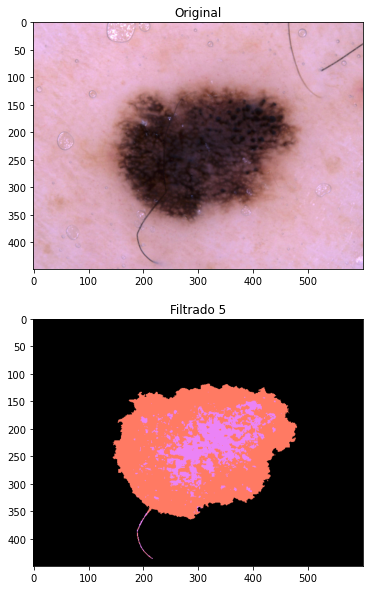

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io, color

def div_n(resLch,n,thresh):
    """
    Divide the image based on its colours(in CIELch) only takes into account the c and h from CIELch. 
    L doesnt change the outcome.
    While it divides the image based on its angle, it always divides c into thirds
    Also it recieves a mask
    
    Parameters:
     resLch[float]: The ingage to be converted in CIELch format, color.rgb2LCH was used, so it expects this format
     n int: the amount that the image will be sectioned into
     thresh [int]: The mask, if the mask is zero at a certain pixel it is not taken into account
     
    Returns:
        resfiltered [float]: The image filtered into the colours, it is rgb format
    """ 
    [h,w,_] = resLch.shape #get width and length of the image
    resfiltered = np.zeros((h,w,3), dtype=float)
    #create the mask, from the CIELab image and the binary image
    pi_n = (2*np.pi)/n
    sorted_ = [ [] for i in range(n*3)]
    length_= 0 
    for y in range(0, h):
        for x in range(0, w):
            if(thresh[y,x] != 0):
                h_ab = resLch[y,x,2]
                if(h_ab < 0):
                    h_ab +=2*np.pi
                c_ab = resLch[y,x,1]
                if(c_ab < 33):
                    length_=0
                    resfiltered[y,x,:] = [70,70,0]
                elif(c_ab < 66):
                    length_=1
                    resfiltered[y,x,:] = [60,80,0]
                else:
                    length_=2
                    resfiltered[y,x,:] = [30,90,0]
                for i in range(n):
                    if(h_ab >(pi_n*i) and h_ab <=(pi_n*(i+1))):
                        resfiltered[y,x,2] = (pi_n*i)+pi_n/2
                        sorted_[(length_*n)+i].append(list(resLch[y,x,:]))
    resfiltered = color.lch2lab(resfiltered)
#     for i in range(n*3):
#         print(i,algo[i],len(sorted_[i]))
    return [color.lab2rgb(resfiltered),sorted_]

def calc_mcdm(sorted_):
    """
    Calculate the MCDM from the list obtained from sorting
    
    Parameters:
     sorted_[int nxmx3]: List containing all of the sorted pixels in an image
     
    Returns:
        mcdm[float n]: Calulcated MCDM for all of the n spaces 
    """ 
    mcdm = []
    for i in range(len(sorted_)):
        mcdm.append(0)
        l_average = np.average([item[0] for item in sorted_[i][:]])
        c_average = np.average([item[1] for item in sorted_[i][:]])
        h_average = np.average([item[2] for item in sorted_[i][:]])
#         print(sorted_[i][:][0][1])
#         print(i,l_average,c_average,h_average)
        n = len(sorted_[i])
        for j in range(n):
            mcdm[i] += np.sqrt(np.power((sorted_[i][:][j][0]-l_average),2)+
                              np.power((sorted_[i][:][j][1]-c_average),2)+
                              np.power((sorted_[i][:][j][2]-h_average),2));
        if(n != 0):
            mcdm[i] = mcdm[i]/n
        else:
            mcdm[i] = 0
        print(i," : ",mcdm[i])
    return mcdm

def colour_lab(imagePath):
    """
    Evaluate the colours of an image
    
    Parameters:
     imagePath[string]: The relative path to the image
     
    Returns:
        score [float]: The score of the colour
    """ 

    image = io.imread(imagePath)
    image_CIELab = color.rgb2lab(image)
    
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Same image but in grayscale, this is done to calculate the threshold
    ret,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#get contours
    cv2.drawContours(thresh, contours, -1, (255,255,255), thickness=cv2.FILLED)#fill in the contours as white
    
    #find largest contour and remove the smaller ones
    max_area = -1
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if area>max_area:
            max_area = area
    
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if (area < max_area):
            cv2.drawContours(thresh, [contours[i]], -1, (0,0,0), thickness=cv2.FILLED)
    
    
    [h,w,_] = image.shape #get width and length of the image
    res = np.zeros((image.shape), dtype=int) #new matrix for the new image
    resLch = color.lab2lch(image_CIELab) #image in CIELch colour space


    #segment the image bases on colours and mask
    [res5,sorted_5] = div_n(resLch,5,thresh)
#     [res8,sorted_8] = div_n(resLch,8,thresh)
#     [res10,sorted_10] = div_n(resLch,10,thresh)
#     [res15,sorted_15] = div_n(resLch,15,thresh)
    
#     print(sorted_5[:][1:10])
#     print(len(sorted_5))
    
    mcdm_5 = calc_mcdm(sorted_5)
#     mcdm_8 = calc_mcdm(sorted_8)
#     mcdm_10 = calc_mcdm(sorted_10)
#     mcdm_15 = calc_mcdm(sorted_15)
    
#     all_mcdm = [mcdm_5,mcdm_8,mcdm_10,mcdm_15]
#     mcdm_num = [5,8,10,15]
#     for i in range(4):
#         print(mmcdm_num[i])
#         for j in range(len(all_mcdm[i])):
#             print(i, " : ", allmcdm[i][j])
    
    
    plt.rcParams['figure.figsize'] = [10, 10]
    fig, axs = plt.subplots(2)
    axs[0].imshow(image)
    axs[0].set_title('Original')
    axs[1].imshow(res5)
    axs[1].set_title('Filtrado 5')
#     axs[2].imshow(res8)
#     axs[2].set_title('Filtrado 8')
#     axs[3].imshow(res10)
#     axs[3].set_title('Filtrado 10')
#     axs[4].imshow(res15)
#     axs[4].set_title('Filtrado 15')
    

# colour_lab('images/firstimages/ISIC_0024640.png') #try it without all of the complexity only n.
# colour_lab('images/firstimages/ISIC_0024545.png')
# colour_lab('images/firstimages/ISIC_0024630.png')
colour_lab('images/firstimages/ISIC_0025313.png')
# colour_lab('images/firstimages/ISIC_0025035.png')
# colour_lab('images/firstimages/ISIC_0024930.png')
# colour_lab('images/firstimages/ISIC_0026120.png')

### D - Dimensión

___

La última característica es la dimensión. A veces también se denomina diámetro [1]. En aras de la coherencia, se considerará aquí como una dimensión. Los dermatólogos generalmente clasifican el tamaño del melanoma potencial como aquellos cuya dimensión es superior a 6 mm [1] [2].

Para calcular esta métrica se utilizará area. Se ofrecerá una explicación general. Se aplicó un umbral a la imagen (de nuevo se utilizará Otsu) para separar la piel sana de la no sana. Una vez hecho esto, el siguiente paso es contar el número de píxeles de lesión (píxeles blancos) que están presentes.

Sin embargo, todavía queda la cuestión de la representación del tamaño físico que representa cada píxel. Este problema se corrige gracias a una herramienta que se está desarrollando junto con este código. Esto tiene como objetivo fijar el ángulo y la distancia desde la piel a la cámara, para mantener cada píxel siempre del mismo tamaño. La correlación, por el momento, no se ha dado. Este valor se agregará más adelante al código. Cabe señalar que sin la herramienta, la solución propuesta no representará el tamaño real de la lesión, lo que significa que el tamaño estimado se vuelve incierto.




[1]Friedman, R. J., Rigel, D. S., & Kopf, A. W. (1985). Early detection of malignant melanoma: The role of physician examination and self-examination of the skin. CA: A Cancer Journal for Clinicians, 35(3), 130–151. https://doi.org/10.3322/canjclin.35.3.130

[2]Crovari Eulufi, F., & Manzor Véliz, M. (2014). Manual de patología quirúrgica. Universidad Católica de Chile. https://www-digitaliapublishing-com.ezproxy.itcr.ac.cr/a/3826



In [5]:
import cv2 #Image Library
import numpy as np #Numpy library
import matplotlib.pyplot as plt #matplotlib to show images

size_of_pixel = 1 #Real size of each pixel

def dimension(imagePath):
    """
    Evaluate the assymetry of an image
    
    Parameters:
     imagePath[string]: The relative path to the image
     
    Returns:
        dimension [int]: The total size of the melanoma
    """ 
    image = cv2.imread(imagePath) #read the image
    [h,w,_] = image.shape #get width and length of the image
    
    roi = image[0:h, 0:w]

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Same image but in grayscale, this is done for calculating the threshold
    _,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    #get contours
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #fill in the contour
    cv2.drawContours(thresh, contours, -1, (255,255,255), thickness=cv2.FILLED)
    #find largest area contour and remove the smaller ones
    max_area = -1
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if area>max_area:
            max_cont = contours[i]
            max_area = area
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if (area < max_area):
            cv2.drawContours(thresh, contours, -1, (0,0,0), 3)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    tot = 0
    for y in range(h):
        for x in range(w):
            if(thresh[y][x]) == 255:
                tot +=1 #count all white pixels
    global size_of_pixel
    dimension = tot * size_of_pixel
    return dimension

#missing evaluation

### Pipeline

In [ ]:
import os, sys
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

#path = "Images/FirstImages"
path = "Images/Paint"
#dirs = os.listdir( path )
#dirs = ["assymetrytest.png"]
dirs = ["M04-F1-001.jpg"]
results= []
for file in dirs:
    curr_img = {}
    curr_img['Image'] = path+"/"+file
    now = datetime.now()
    curr_img['Date'] = now.strftime("'%d/%m/%Y %H:%M:%S")
    print("Start: "+now.strftime("%d/%m/%Y %H:%M:%S"))
    #Assymetry
    curr_img['Start_Assymetry'] = now.strftime("'%d/%m/%Y %H:%M:%S")
    assymetry_res = assymetry(path+"/"+file)
    curr_img['Assymetry_x'] = assymetry_res[0]
    curr_img['Assymetry_y'] = assymetry_res[1]
    curr_img['Assymetry_tot'] = assymetry_res[2]
    now = datetime.now()
    curr_img['End_Assymetry'] = now.strftime("'%d/%m/%Y %H:%M:%S")
    #Border_def
    curr_img['Start_Border_def'] = now.strftime("'%d/%m/%Y %H:%M:%S")
    curr_img['Border_def'] = border_definition(path+"/"+file)
    now = datetime.now()
    curr_img['End_Border_def'] = now.strftime("'%d/%m/%Y %H:%M:%S")
    #Border_fractality
    curr_img['Start_Border_frc'] = now.strftime("'%d/%m/%Y %H:%M:%S")
    curr_img['Border_frc'] = image_fractality(path+"/"+file)
    now = datetime.now()
    curr_img['End_Border_frc'] = now.strftime("'%d/%m/%Y %H:%M:%S")
    #Border_colour
    curr_img['Start_Colour'] = now.strftime("'%d/%m/%Y %H:%M:%S")
    curr_img['Colour'] = colour(path+"/"+file)[0]
    now = datetime.now()
    curr_img['End_Colour'] = now.strftime("'%d/%m/%Y %H:%M:%S")
    #Border_dimension
    curr_img['Start_Border_dimension'] = now.strftime("'%d/%m/%Y %H:%M:%S")
    curr_img['Dimension'] = dimension(path+"/"+file)
    now = datetime.now()
    curr_img['End_Border_dimension'] = now.strftime("'%d/%m/%Y %H:%M:%S")
    #Results
    results.append(curr_img)

now = datetime.now()
print("End: "+now.strftime("%d/%m/%Y %H:%M:%S"))
df = pd.DataFrame.from_dict(results)
df.to_csv (r'results/'+now.strftime("%d-%m-%Y_%H-%M")+'.csv', index = False, header=True)

Start: 30/09/2021 07:33:43


https://www.sciencedirect.com/science/article/pii/S2666285X21000017

Clinical Diagnosis of Melanoma: LR+ and LR- https://www.aafp.org/afp/2008/1115/p1205.html

Sensitivity and Specificity https://pubmed.ncbi.nlm.nih.gov/9693179/ From a computer standpoint https://www.sciencedirect.com/science/article/pii/S2666285X21000017 https://ieeexplore.ieee.org/abstract/document/8252041?casa_token=zzaJtxkhKYsAAAAA:ohftyhDFnL7y6euPybF2ET5tCTFjgTfgdzTZXNsLB6gStE04HVf78vtGJ6niUTqPlwMyaHS3YPc


Overall results: https://pubmed.ncbi.nlm.nih.gov/8157780/

# Estimación de Melanoma

In medicine when a condition is to be either to be asserted or denied via a test there are parameters that help the desicion of which test to use. One of the most important of these parameters are the likelihood ratios (LR). These ratios are related to the concepts of sensitivity and specificity, which are borrowed from mathematics. The ratios can be either positive(LR+) or negative(LR-). A positive ratio is used to rule in a disorder via a test and the negative to rule out a disorder via a test. These are used to minimize the amount of tests needed to diagnose patients. 

In this case we will use a positive likelihood ratio, since this project is aiming to detect/diagnose melanomas. In case it was trying to rule out melanomas a negtive LR would be used. As for the issue of which values to use exactly, this project is selecting the values from previous research [1]

[1] https://www.aafp.org/afp/2008/1115/p1205.html